# Linear Models - Feature Contribution Analysis and Feature Annotation

This notebook mainly contains:<br>
(1) Leave one feature out predictions to assess importance of each feature<br>
(2) Alternative random feature pertubation

**Inputs**

Single file containing all the 47 task contrasts for all 254 subejcts (for LH)<br>
`/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.raw.npy`

Single files containing the data of all 254 subejcts per predictor modality (for LH)<br>
given as dics, with subject numbers beeing the key, and values beeing of shape (29696, d)<br>
e.g. for "RS-PCA200": `all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy`

**Outputs**

PCA per-feature pertubation results<br>
`results/scores/pertubation_pca.yfull.from_zscored.npy`

Difference in discriminability per feature and task<br>
`results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yfull.npy`

Random 10% feature pertubations<br>
`pertubation_pca.random.yresid.from_zscored.npy`

In [7]:
import torch
import numpy as np
import scipy
from tqdm import tqdm

# Model fitting and scoring functions
import sklearn.linear_model
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split, ShuffleSplit

import sys
sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")

from lib.stats import compute_all_scores, compute_scores
from lib.stats import np_pearson_cor
from lib.stats import comp_dice, comp_corr, r2_score, comp_tsss_similiarity, comp_cosine_similiarity
from lib.stats import compute_batch_differentiability_score
from lib.linear_models import predict_y_from_x, predict_from_modality_file, approximate_best_alphas, score

desired_scores = {"corr": comp_corr, "r2_score": r2_score};


# plotting libraries
from matplotlib import pyplot as plt

from lib.plotting import plot_corr_scores, plot_29k
from matplotlib.colors import ListedColormap
import os, brainspace
import hcp_utils as hcp
from lib.plotting import plot_gen_surf2, centered_minmax
stub = os.path.dirname(brainspace.__file__) + "/datasets/surfaces/"


from lib.plotting import plot_29k


/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Definition of prdedictors and targets

In [2]:
# general data 
data_dir = "/scratch/users/robert.scholz2/acc_dists/"
subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);

In [3]:
# prediction modality files
pred_files = {
    "RS-ICA200": "all_ICAmaps_254_full_unrelated.L.c200.npy",
    "RS-PCA200" : "all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy",
    "Distance to Parcels (raw)": "all_dists_254_full_unrelated.centroid_dist.raw.npy",
    "SC Blueprints": "all_blueprints_BPsubset247.npy",
    "SEmodes": "all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.procAlignGrp.npy",
    "Distance-PCAgra" : "all_dists_254_full_unrelated.29x200.grPCA_aligned.L.npy",
    "Distance-PCAsal" : "all_dists_254_full_unrelated.29x200.aligned_to_131217.L.npy",
    "FS-StructuralMaps": "all_fs_struct_254_full_unrelated.L.npy",
}

In [4]:
# prediction targets

fn = "/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.raw.npy"
yfull_task_data =np.load(fn, allow_pickle=True).item()

print("Number of subjects in task data file:", len(yfull_task_data))
print("First 5 subject ids:", list(yfull_task_data.keys())[:5])
print("Each subjects' task data has the shape:", yfull_task_data["100206"].shape)

y_task_data = yfull_task_data 

Number of subjects in task data file: 254
First 5 subject ids: ['100206', '100610', '101006', '101309', '101915']
Each subjects' task data has the shape: (29696, 47)


# Leave one out predictions (for RS-PCA)

## Loading of the data

In [18]:
from lib.data_loading import gather_modalities, load_xy_data

In [19]:
combination = ["RS-PCA200"];
comb_predictors = gather_modalities(subjs, combination, pred_files, zscore_predictors=False, modality_cache=None);
# this additionally z-scores the y_task_data
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, y_task_data, zscore_tasks=True)

zdim = 0
if not(zdim is None):
  print(f"z-scoring predictors along dimension {zdim} of size {xdata.shape[zdim]}")
  xdata = scipy.stats.zscore(xdata, axis= zdim)

n_pred = xdata.shape[-1]  
print(n_pred, xdata.shape, ydata.shape)

Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 114.41it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along dimension 0 of size 254
200 (254, 29696, 200) (254, 29696, 47)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=False)
x = x_train.reshape((-1, x_train.shape[-1]))
y = y_train.reshape((-1, y_train.shape[-1]))
xt = x_test.reshape((-1, x_test.shape[-1]))
skr = sklearn.linear_model.LinearRegression()

## Full feature baseline

In [21]:
# get the full-features baseline to compare against
y_train, y_train_pred, y_test, y_test_pred, skr = predict_y_from_x(xdata, ydata, verbose=1, lmodel="linear")
scoresd, diff_scores_test = score(y_test_pred, y_test);
baseline_diff = diff_scores_test
baseline_corr = scoresd.corr.mean(0)
print(baseline_diff)

(203, 29696, 200) (203, 29696, 47) (51, 29696, 200) (51, 29696, 47)
(6028288, 200) (6028288, 47)
[0.15772232 0.14394217 0.15459464 0.22700102 0.22848868 0.05451082
 0.22034964 0.23481876 0.28359185 0.22120995 0.15862779 0.13049487
 0.14907837 0.12396064 0.12640758 0.17009516 0.20462007 0.06354996
 0.06427077 0.06500841 0.05789746 0.06738369 0.21785659 0.23464312
 0.14163186 0.21580799 0.24087034 0.16915579 0.22017131 0.23527882
 0.21391188 0.20930996 0.16552143 0.17255001 0.17844421 0.19010549
 0.24682304 0.20626495 0.21074625 0.21212193 0.22874845 0.21356116
 0.21612945 0.09938611 0.11267054 0.11837956 0.07132536]


## Perturb features one by one

In [22]:
cscores = []
dscores = []

x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=False)
x = x_train.reshape((-1, x_train.shape[-1]))
y = y_train.reshape((-1, y_train.shape[-1]))
xt = x_test.reshape((-1, x_test.shape[-1]))

test_those=np.arange(x_test.shape[-1])
    
for i in tqdm(test_those): # [:4]):
    
  # perturb one feature at a time
  x_pert = x.copy(); x_pert[:,i]=0;
  skr.fit(x_pert, y)

  xt_pert=xt.copy(); xt_pert[:,i]=0
  y_test_pred =skr.predict(xt_pert).reshape(y_test.shape)

  scoresd, diff_scores_test = score(y_test_pred, y_test);
  cscores.append(scoresd.corr.mean(0))  
  dscores.append(diff_scores_test)

100%|██████████| 200/200 [2:14:12<00:00, 40.26s/it]  


In [23]:
# Save the purtubation results

pl = {"dscores":np.array(dscores), "cscores": np.array(cscores), "baseline_diff": baseline_diff, "baseline_corr": baseline_corr, "skr":skr}
#np.save("results/scores/pertubation_pca.yfull.from_zscored.npy", pl)

## Visualize the pertubation results

In [5]:
p = np.load("results/scores/pertubation_pca.yfull.from_zscored.npy", allow_pickle=1).item()
dscores = p["dscores"]; cscores = p["cscores"]; baseline_diff = p["baseline_diff"]; baseline_corr =p["baseline_corr"];
p.keys()

dict_keys(['dscores', 'cscores', 'baseline_diff', 'baseline_corr', 'skr'])

In [6]:
# Calculate the score difference between full feature and perturbed models (on a per task basis)

diff = (baseline_diff - np.array(dscores))
corr = (baseline_corr - np.array(cscores))
diff.shape

(200, 47)

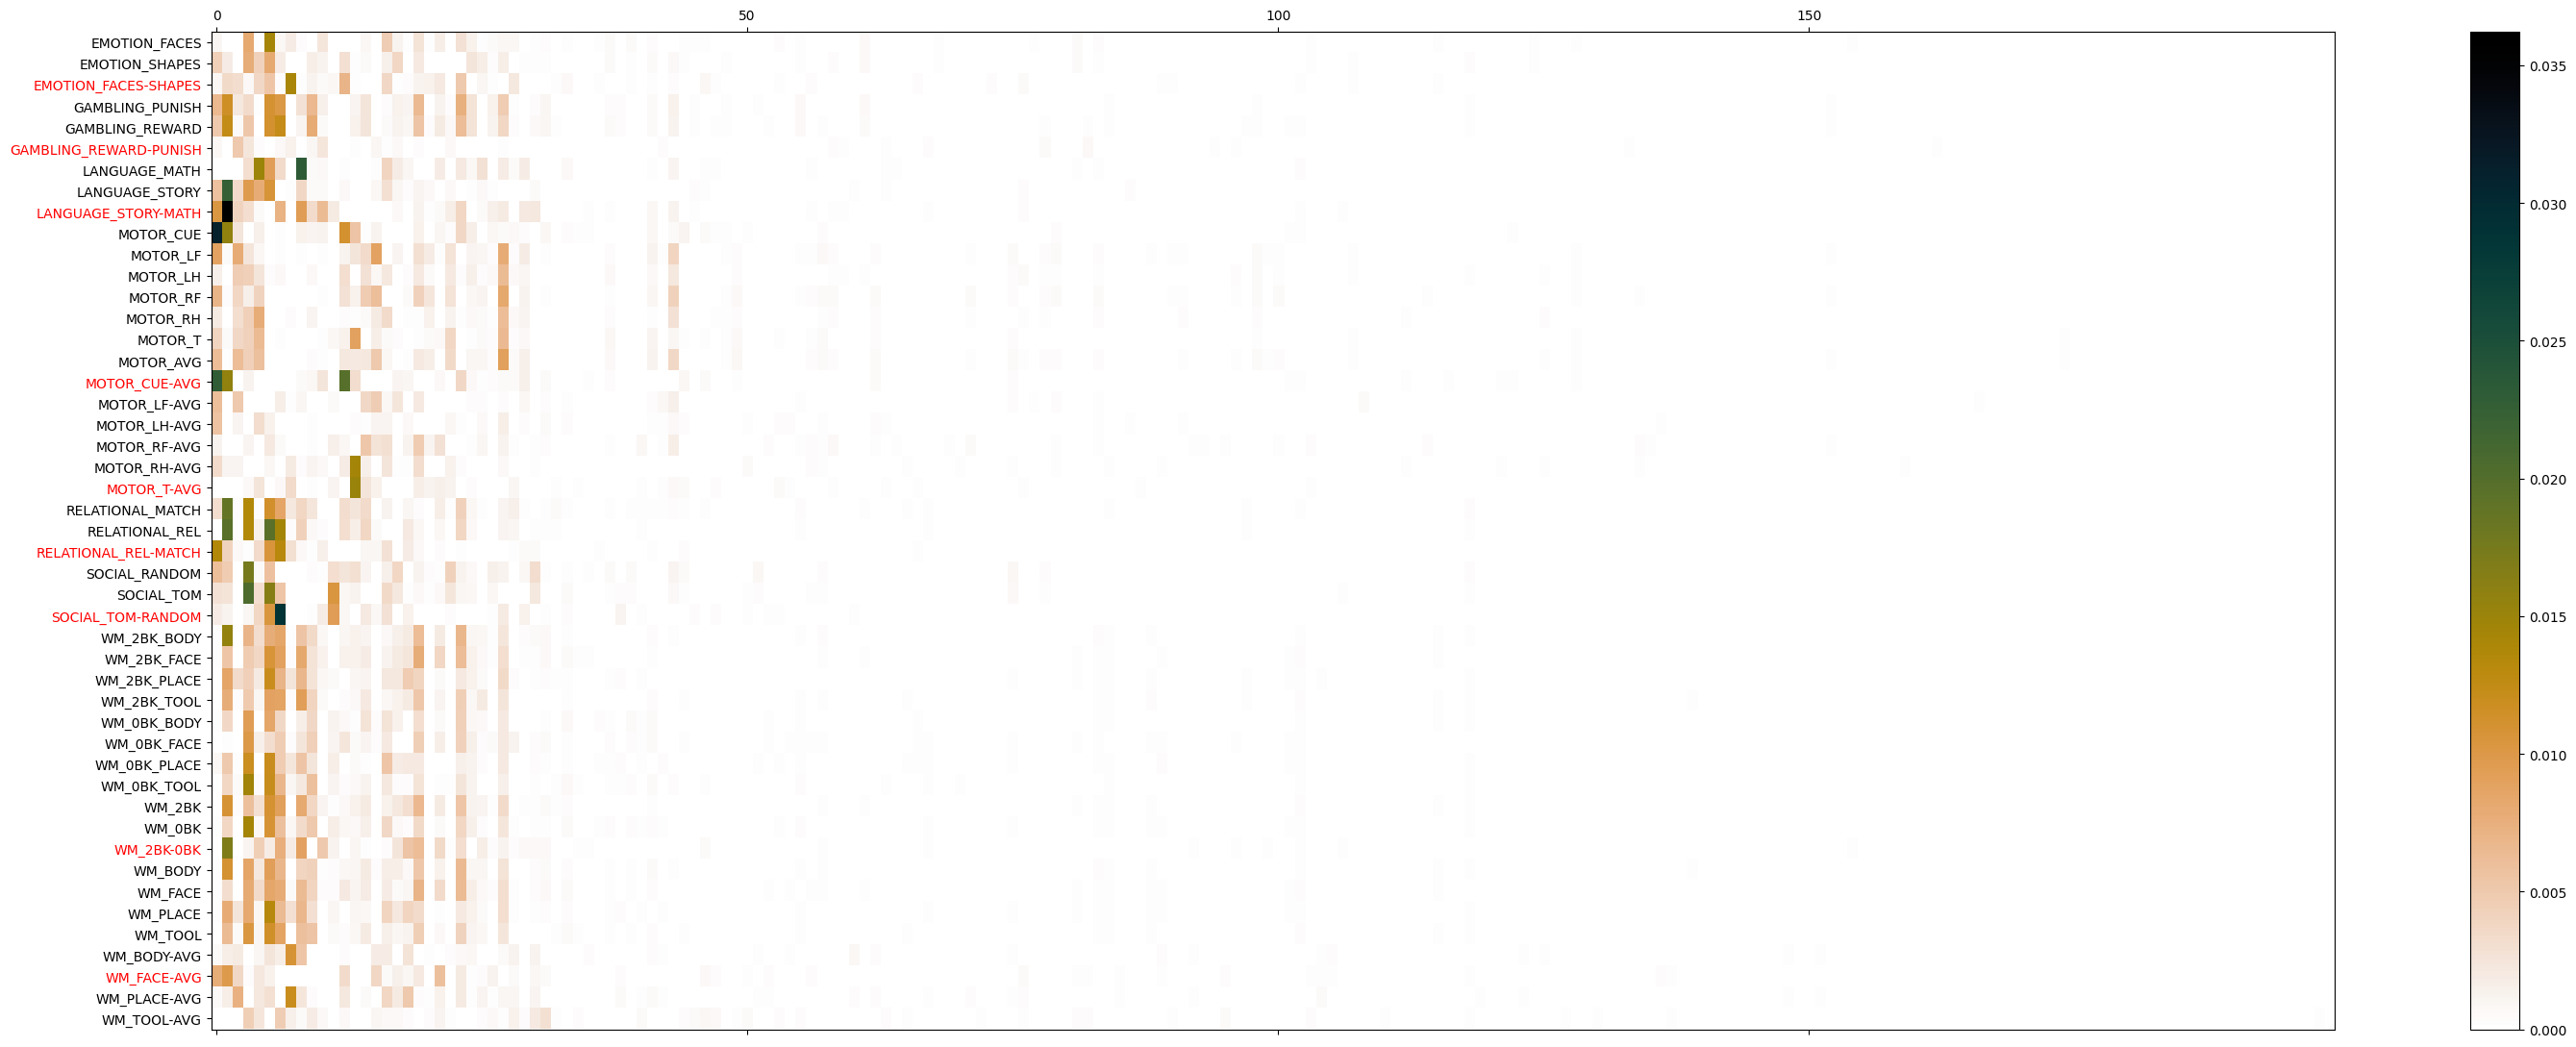

In [26]:
# Visualization of the full results

import cmasher as cmr
import cmcrameri.cm as cmc
cmap_coeffs = "cmr.prinsenvlag_r" #cmc.vik #"PiYG"
def fxdcolorbar(mappable, *args,**kwargs): from mpl_toolkits.axes_grid1 import make_axes_locatable; last_axes = plt.gca(); ax = mappable.axes; fig = ax.figure; divider = make_axes_locatable(ax);  cax = divider.append_axes("right", size="5%", pad=0.05); cbar = fig.colorbar(mappable, cax=cax, *args,**kwargs); plt.sca(last_axes); return cbar;
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

cmap_seq = "cmr.savanna_r"#"cmc.batlow"#" #cmc.vik #"PiYG"

v = np.absolute(diff).max()
ax = plt.figure(figsize=(30,11)).gca()
im = ax.matshow(diff.T, cmap =cmap_seq , vmin=0, vmax=v*0.5, aspect=2); plt.colorbar(im, ax=ax)#fxdcolorbar(im);
plt.yticks(np.arange(len(unique_contrasts)), unique_contrasts);
for label in np.array(ax.get_yticklabels())[contrast_ids_to_show]: label.set_color("red")

plt.tight_layout()
#plt.savefig("results/plots/XXrs_pca.lin_weight_onebyone_contrib.diff.200.spatial_zscore.yfull.png")

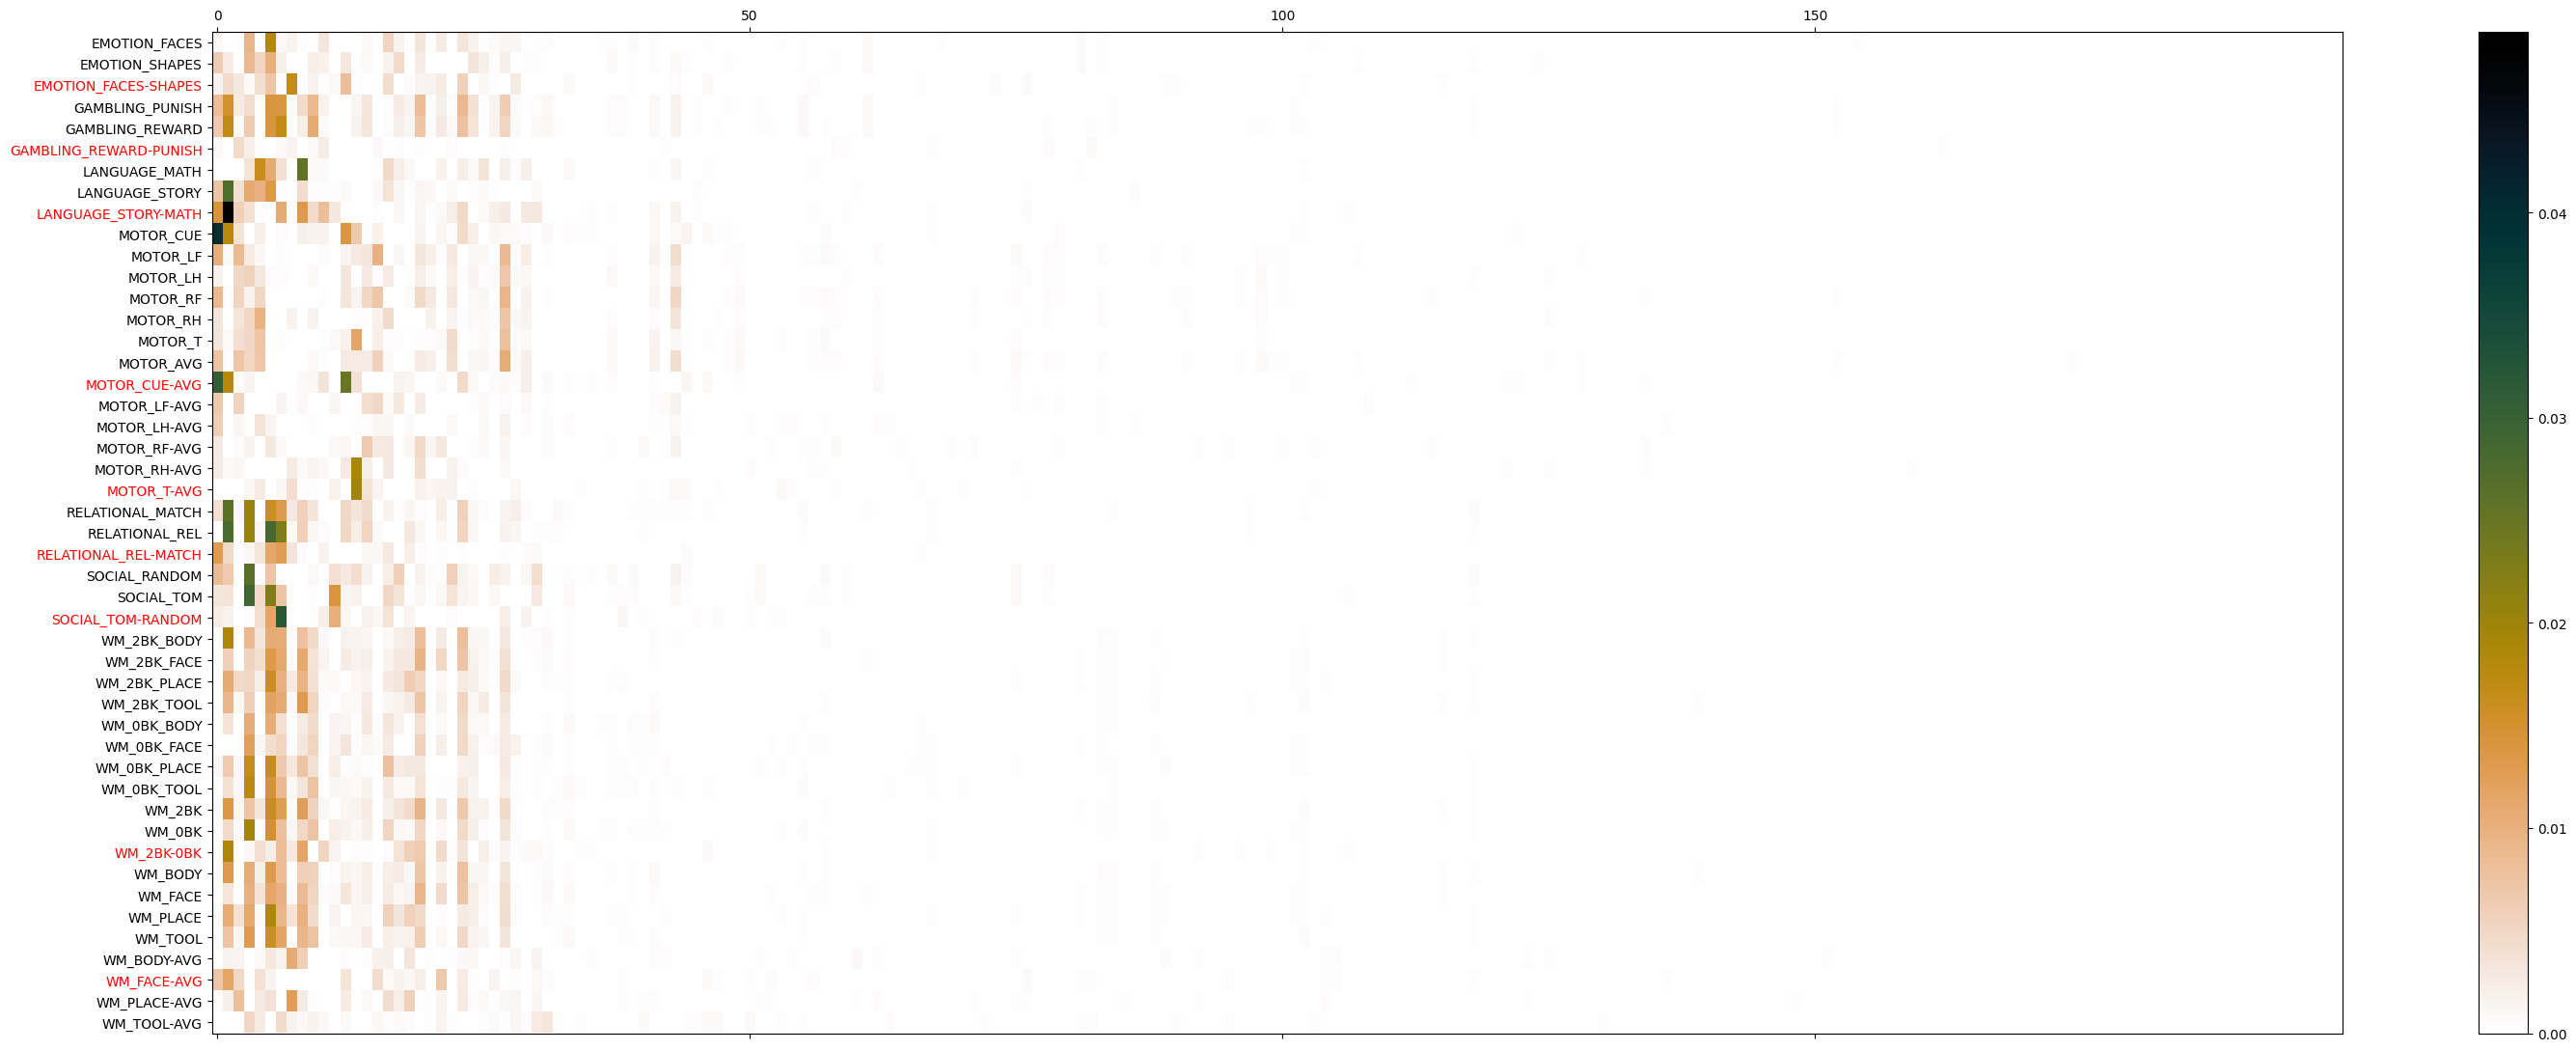

In [10]:
# Same based on models predicting residualized task contrasts
# (requires change to the target definition: 
# y_task_data =np.load("/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.yresid.npy", allow_pickle=True).item()

cmap_seq = "cmr.savanna_r"
v = np.absolute(diff).max()
ax = plt.figure(figsize=(30,11)).gca()
im = ax.matshow(diff.T, cmap =cmap_seq , vmin=0, vmax=v*0.5, aspect=2); plt.colorbar(im, ax=ax)#fxdcolorbar(im);
plt.yticks(np.arange(len(unique_contrasts)), unique_contrasts);
for label in np.array(ax.get_yticklabels())[contrast_ids_to_show]: label.set_color("red")

plt.tight_layout()
plt.savefig("results/plots/rs_pca.lin_weight_onebyone_contrib.diff.200.spatial_zscore.yresid.png")

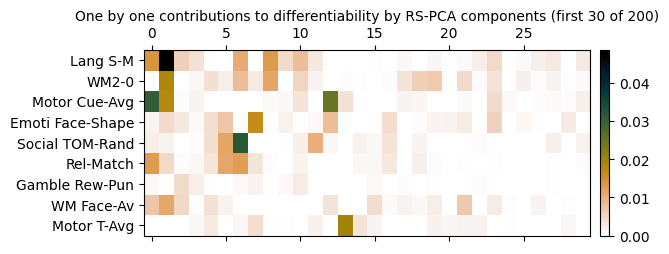

In [54]:
# Visualization of the main contrasts of interest

coeffs = diff.T
fig, axs = plt.subplots(1,1, figsize=(6,2.7)) # 4 plots in a row
axs=[axs];

coeffs2show = coeffs[contrast_ids_to_show,:]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
#im = axs[0].matshow(data, cmap = cmap_seq, vmin=-v, vmax=v, aspect=aspr); 
im = axs[0].matshow(data, cmap = cmap_seq, vmin=0, vmax=v*0.5, aspect=aspr); 
#for (i, j), z in np.ndenumerate(coeffs2show): 
#  if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xlabel(f"One by one contributions to differentiability by RS-PCA components (first {n_comps} of 200)"); axs[0].xaxis.set_label_position('top') 
plt.savefig("results/plots/rs_pca.lin_weight_onebyone_contrib.diff.30.spatial_zscore.yresid.png")

In [93]:
fn = "results/scores/rs_pca.lin_weight_onebyone_contrib.values.diff.spatial_zscore.yfull.npy"
data = dict(contr=diff.T, unique_contrasts=unique_contrasts, contrast_ids_to_show = contrast_ids_to_show, best = best_coefficients_full);
np.save(fn, data)

## Listing of list highest coefficients per component:

In [90]:
# list 10 best coefficients per component:
for cn in range(best_coefficients.shape[0]):
  cname = tnames_mid[cn]; 
  p1 = cname +  (17-len(cname))*" " + str( list(best_coefficients[cn, :10])); 
  print(p1, (55-len(p1))*" " , list(coeffs2show[cn,  best_coefficients[cn, :10]].round(4)))

Lang S-M         [1, 0, 8, 6, 10, 2, 23, 9, 3, 30]       [0.0976, 0.0142, 0.0132, 0.0108, 0.0082, 0.0058, 0.0047, 0.0045, 0.0038, 0.003]
WM2-0            [1, 8, 6, 19, 18, 10, 21, 4, 23, 17]    [0.0185, 0.0116, 0.0084, 0.0066, 0.0058, 0.0052, 0.0045, 0.004, 0.0036, 0.0034]
Motor Cue-Avg    [0, 12, 1, 23, 13, 10, 29, 17, 3, 18]   [0.0306, 0.0249, 0.0179, 0.0046, 0.0038, 0.0035, 0.0021, 0.0015, 0.0014, 0.0012]
Emoti Face-Shape [7, 12, 5, 23, 1, 16, 4, 2, 28, 21]     [0.0166, 0.0081, 0.0071, 0.0056, 0.0046, 0.0044, 0.0041, 0.003, 0.0026, 0.0024]
Social TOM-Rand  [6, 5, 11, 4, 16, 27, 0, 10, 14, 1]     [0.0317, 0.0115, 0.0102, 0.0041, 0.0034, 0.0022, 0.0021, 0.0019, 0.0018, 0.0017]
Rel-Match        [0, 6, 5, 1, 7, 4, 16, 18, 10, 14]      [0.0128, 0.0127, 0.0114, 0.0046, 0.0033, 0.0031, 0.003, 0.0019, 0.0016, 0.0011]
Gamble Rew-Pun   [2, 1, 10, 3, 7, 5, 6, 9, 15, 0]        [0.0045, -0.0036, 0.0023, 0.0022, 0.0014, -0.0013, 0.0008, 0.0008, 0.0008, 0.0008]
WM Face-Av       [1, 0, 21, 2, 15, 4

In [92]:
# list 10 best coefficients per component:

best_coefficients_full = np.argsort(np.absolute(coeffs), axis=1)[:,::-1]
for cn in range(best_coefficients_full.shape[0]):
  cname = unique_contrasts[cn]; 
  p1 = cname +  (17-len(cname))*" " + str( list(best_coefficients_full[cn, :10])); 
  print(p1, (55-len(p1))*" " , list(coeffs[cn,  best_coefficients_full[cn, :10]].round(4)))

EMOTION_FACES    [5, 3, 16, 19, 10, 23, 21, 24, 7, 17]   [0.0183, 0.0093, 0.0053, 0.0033, 0.0032, 0.0031, 0.0024, 0.0018, 0.0016, 0.0016]
EMOTION_SHAPES   [5, 3, 0, 4, 17, 24, 12, 7, 19, 1]      [0.0102, 0.0088, 0.0063, 0.0052, 0.0045, 0.0033, 0.003, -0.0024, 0.0024, 0.0023]
EMOTION_FACES-SHAPES[7, 12, 5, 23, 1, 16, 4, 2, 28, 21]  [0.0166, 0.0081, 0.0071, 0.0056, 0.0046, 0.0044, 0.0041, 0.003, 0.0026, 0.0024]
GAMBLING_PUNISH  [1, 5, 6, 23, 9, 19, 0, 27, 8, 3]       [0.0151, 0.014, 0.0137, 0.009, 0.0089, 0.0083, 0.0083, 0.0063, 0.0044, 0.0042]
GAMBLING_REWARD  [1, 6, 5, 9, 23, 19, 3, 0, 27, 24]      [0.0171, 0.0167, 0.0141, 0.0108, 0.0077, 0.0071, 0.0066, 0.0066, 0.0053, 0.0035]
GAMBLING_REWARD-PUNISH[2, 1, 10, 3, 7, 5, 6, 9, 15, 0]   [0.0045, -0.0036, 0.0023, 0.0022, 0.0014, -0.0013, 0.0008, 0.0008, 0.0008, 0.0008]
LANGUAGE_MATH    [8, 4, 5, 16, 6, 3, 25, 23, 17, 29]     [0.0255, 0.0161, 0.0107, 0.0046, 0.0038, 0.0036, 0.0034, 0.0022, 0.0022, 0.0021]
LANGUAGE_STORY   [1, 5, 3, 4, 0, 8,

## Alternative: Random Pertubation of 10% of features)

In [69]:
from tqdm.notebook import tqdm
n_pertubations = int(n_pred*0.1); #20; try to perturb always around 10% of the features
n_perm = 1000; #int(5*n_pred); 
random_feature_subsets = np.zeros((n_perm, n_pertubations)).astype(int);

np.random.seed(110)
for i in range(n_perm):
  random_feature_subsets[i,:] = np.random.permutation(n_pred)[:n_pertubations]

In [71]:
from tqdm import tqdm

In [ ]:
cscores = []
dscores = []
    
for feat_set in tqdm(random_feature_subsets[:4]):
  x_pert = x.copy(); x_pert[:,feat_set]=0;
  skr.fit(x_pert, y)
  xt_pert=xt.copy(); xt_pert[:,feat_set]=0
  y_test_pred =skr.predict(xt_pert).reshape(y_test.shape)
  scoresd, diff_scores_test = score(y_test_pred, y_test);
  cscores.append(scoresd.corr.mean(0))  
  dscores.append(diff_scores_test)

print(len(dscores))

In [ ]:
np.save("pertubation_pca.random.yresid.from_zscored.npy", {"dscores":np.array(dscores), "cscores": np.array(cscores), "baseline": baseline_diffscore})